In [30]:
import pandas as pd
df_ours_gene = pd.read_csv('./table.1-2.TPM.gene.by.Tumor.csv', index_col=0)
import numpy as np
# df_ours_common.shape
from scipy.stats import rankdata
from sklearn.linear_model import LogisticRegression, LinearRegression


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def quantile_normalize_scipy(df, log2=True):
    """
    使用scipy实现的更快速的分位数归一化 (按行进行归一化)
    """
    # 转换为numpy数组
    data = df.values
    if log2:
        print(f"before log2: {data.min()}, {data.max()}")

        data = np.log2(data+2)

        print(f"after log2: {data.min()}, {data.max()}")
    else:
        print(f"No use log2")
    
    # 计算每行的排名
    rank_data = np.array([rankdata(row) for row in data])
    
    # 计算排序后的均值
    sorted_means = np.mean(np.sort(data, axis=1), axis=0)
    
    # 根据排名分配新值
    normalized_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        normalized_data[i] = sorted_means[rank_data[i].astype(int)-1]
    
    return pd.DataFrame(normalized_data, index=df.index, columns=df.columns)


def quantile_normalize_with_na(df, log2=True):
    """
    处理含有缺失值的分位数归一化
    """
    # 记录缺失值位置
    na_mask = df.isna()
    
    # 对非缺失值进行归一化
    df_filled = df.fillna(df.min().min() - 1)  # 临时填充一个小值
    normalized = quantile_normalize_scipy(df_filled, log2=log2)
    
    # 恢复缺失值
    normalized[na_mask] = np.nan
    
    return normalized
# df_com_normalized = quantile_normalize_with_na(df_com)
df_ours_qn = quantile_normalize_with_na(df_ours_gene, log2=False)
df_ours_qn
df_ours_qn_filtered = df_ours_qn
df_ours_qn_filtered_log2 = np.log2(df_ours_qn_filtered+1)
df_ours_qn_filtered_log2_d = df_ours_qn_filtered_log2.describe()
df_ours_qn_filtered_log2_d
filter_criteria = df_ours_qn_filtered_log2_d.T['mean'] > 1
print(f"after filter, {filter_criteria.sum()} genes")
df_ours_qn_filtered_log2_filtered = df_ours_qn_filtered_log2.loc[:, filter_criteria]

brca_related_file = pd.read_csv('BRCA_related.genes.csv')
brca_genes = list(set(brca_related_file['core_genes'].tolist() + brca_related_file['extended_genes'].tolist()))
overlapping_genes = list(set(df_ours_qn_filtered_log2_filtered.columns).intersection(brca_genes))
df2=df_ours_qn_filtered_log2_filtered[overlapping_genes]
df_ours_marker = pd.read_csv('table.4-2.clinical.with.multi-omics-allmarker.txt', sep='\t', index_col=0)
target = df_ours_marker['tnbc_meth_CDKN2A@chr9_21991219_21993173']
df_trans = pd.read_csv('./public_data/table.Sammuel2022.Log2No.zscoreNo.txt',sep='\t', index_col=0)
df_trans = df_trans.T

df_wolf = pd.read_csv('./public_data/table.Wolf2022.Log2No.zscoreNo.txt',sep='\t', index_col=0)
df_wolf = df_wolf.T
df_wolf_id_1 = pd.read_csv('table.2-1.Wolf2022.ER-HER2-.SampleID.txt',sep='\t',header=None)
df_wolf_id_2 = pd.read_csv('table.2-1.Wolf2022.ER-HER2+.SampleID.txt',sep='\t',header=None)
df_wolf_id_3 = pd.read_csv('table.2-1.Wolf2022.ER+HER2+.SampleID.txt',sep='\t',header=None)
df_wolf_id_combined = pd.concat([df_wolf_id_1, df_wolf_id_2, df_wolf_id_3])

df_wolf_filtered = df_wolf.loc[df_wolf_id_combined.values.reshape(-1)]

df_hoog = pd.read_csv('./public_data/table.Hoogstraat2023.Log2No.zscoreNo.txt',sep='\t', index_col=0)
df_hoog = df_hoog.T

df_bright = pd.read_csv('./public_data/table.BrighTNess.Log2No.zscoreNo.txt',sep='\t', index_col=0)
df_bright = df_bright.T

df_hatz = pd.read_csv('./public_data/table.Hatzis2011.Log2No.zscoreNo.txt',sep='\t', index_col=0)
df_hatz = df_hatz.T

df_sam = pd.read_csv('./public_data/table.Sammuel2022Val.Log2No.zscoreNo.txt', index_col=0, sep='\t')
df_sam = df_sam.T
# 获取三个数据框的共同列
common_genes = list(set(df2.columns).intersection(df_trans.columns).intersection(df_wolf_filtered.columns))

# 只保留共同的基因列
df2 = df2[common_genes]

# 确保目标变量和特征有相同的样本
common_samples = list(set(target.index).intersection(set(df2.index)))
print(f"共同样本数量: {len(common_samples)}")

target = target.loc[common_samples]
df2 = df2.loc[common_samples]
# 处理缺失值
print(f"\n目标变量中缺失值数量: {target.isna().sum()}")
print(f"基因数据中缺失值数量: {df2.isna().sum().sum()}")

# 移除特征中的缺失值
df2 = df2.dropna(axis=1)

# df2 = df2[['CDKN2A']]
# 检查是否目标变量有缺失值
if target.isna().sum() > 0:
    valid_samples = ~target.isna()
    target = target.loc[valid_samples]
    df2 = df2.loc[valid_samples]
    print(f"移除缺失值后的样本数量: {len(target)}")


######################################### try this ##################################################################
################### very important, to keep the same order of samples in df2 and target, ############################
# otherwise, after train_test_split, the order of X_train and X_val are not the same even for the same random_state #
#####################################################################################################################
# df2 = df2.sort_index(axis=1)
X_train_idx, X_val_idx = pd.read_csv('./sample_idx/cdkn2a_ours_train_samples.csv', header=None), pd.read_csv('./sample_idx/cdkn2a_ours_val_samples.csv', header=None)

# 分割数据集用于特征选择
X_train, X_val, y_train, y_val = df2.loc[X_train_idx.values.reshape(-1)], df2.loc[X_val_idx.values.reshape(-1)], target.loc[X_train_idx.values.reshape(-1)], target.loc[X_val_idx.values.reshape(-1)]


No use log2
after filter, 12918 genes
共同样本数量: 140

目标变量中缺失值数量: 2
基因数据中缺失值数量: 0
移除缺失值后的样本数量: 138



特征选择训练集样本数: 98
特征选择验证集样本数: 40

训练LASSO特征选择模型...
model: LassoCV(alphas=array([0.001     , 0.00104762, 0.0010975 , 0.00114976, 0.0012045 ,
       0.00126186, 0.00132194, 0.00138489, 0.00145083, 0.00151991,
       0.00159228, 0.0016681 , 0.00174753, 0.00183074, 0.00191791,
       0.00200923, 0.0021049 , 0.00220513, 0.00231013, 0.00242013,
       0.00253536, 0.00265609, 0.00278256, 0.00291505, 0.00305386,
       0.00319927, 0.0033516 , 0.00351119, 0.00367838, 0.00385353,
       0.004037...
       0.02595024, 0.02718588, 0.02848036, 0.02983647, 0.03125716,
       0.03274549, 0.03430469, 0.03593814, 0.03764936, 0.03944206,
       0.04132012, 0.04328761, 0.04534879, 0.0475081 , 0.04977024,
       0.05214008, 0.05462277, 0.05722368, 0.05994843, 0.06280291,
       0.06579332, 0.06892612, 0.07220809, 0.07564633, 0.07924829,
       0.08302176, 0.0869749 , 0.09111628, 0.09545485, 0.1       ]),
        cv=98, max_iter=10000, n_jobs=-1, random_state=42)
特征选择模型最佳alpha值: 0.024771

模型性能:
训练集 R²: 0.581

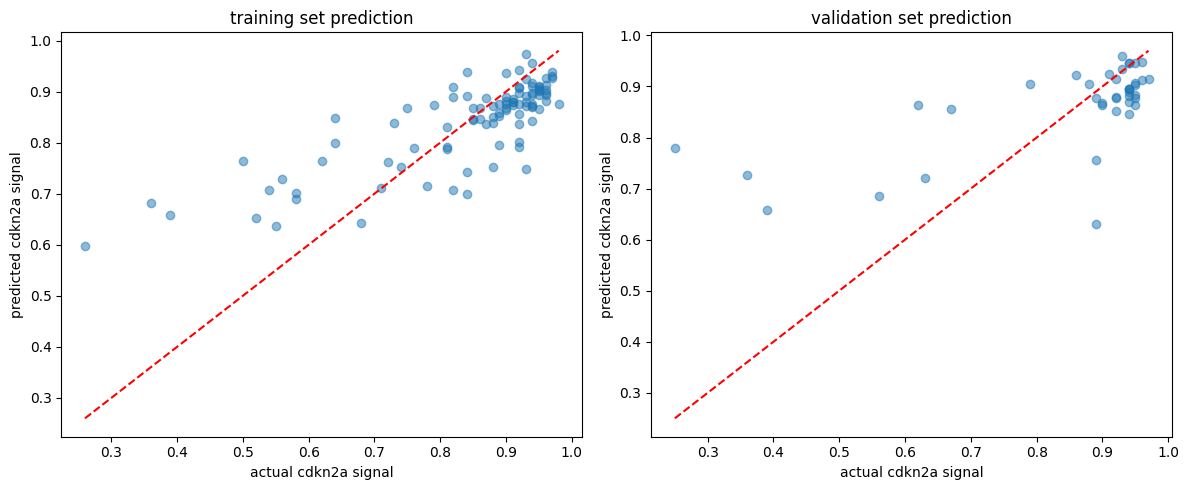


选择的基因数量: 7
feauture list: ['AREG', 'KLK5', 'SIRT1', 'CDK2', 'RNF8', 'UBASH3B', 'CDKN2A']
特征选择率: 0.0099

使用全部数据训练最终模型...
最终模型训练完成


In [14]:


print(f"\n特征选择训练集样本数: {X_train.shape[0]}")
print(f"特征选择验证集样本数: {X_val.shape[0]}")

# 标准化特征
scaler_feature_selection = StandardScaler()     # zscore
X_train_scaled = pd.DataFrame(
    scaler_feature_selection.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
X_val_scaled = pd.DataFrame(
    scaler_feature_selection.transform(X_val),
    index=X_val.index,
    columns=X_val.columns
)

# 构建LASSO模型进行特征选择
print("\n训练LASSO特征选择模型...")
lasso_feature_selector = LassoCV(
    cv=98,
    alphas=np.logspace(-3, -1, 100),
    max_iter=10000,
    n_jobs=-1,
    random_state=42
)
print(f"model: {lasso_feature_selector}")
lasso_feature_selector.fit(X_train_scaled, y_train)
print(f"特征选择模型最佳alpha值: {lasso_feature_selector.alpha_:.6f}")

# 得到预测
train_pred = lasso_feature_selector.predict(X_train_scaled)
val_pred = lasso_feature_selector.predict(X_val_scaled)

# 评估模型性能
train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)
train_mse = mean_squared_error(y_train, train_pred)
val_mse = mean_squared_error(y_val, val_pred)

# Spearman相关系数
train_corr, train_p = stats.spearmanr(y_train, train_pred)
val_corr, val_p = stats.spearmanr(y_val, val_pred)

print("\n模型性能:")
print(f"训练集 R²: {train_r2:.4f}, MSE: {train_mse:.4f}")
print(f"验证集 R²: {val_r2:.4f}, MSE: {val_mse:.4f}")
print(f"训练集 Spearman相关系数: {train_corr:.4f} (p={train_p:.4f})")
print(f"验证集 Spearman相关系数: {val_corr:.4f} (p={val_p:.4f})")



# 可视化预测结果
plt.figure(figsize=(12, 5))

# 训练集预测
plt.subplot(121)
plt.scatter(y_train, train_pred, alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
plt.xlabel('actual cdkn2a signal')
plt.ylabel('predicted cdkn2a signal')
plt.title('training set prediction')

# 验证集预测
plt.subplot(122)
plt.scatter(y_val, val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('actual cdkn2a signal')
plt.ylabel('predicted cdkn2a signal')
plt.title('validation set prediction')

plt.tight_layout()
plt.show()

# 提取非零系数特征
non_zero_coefs = pd.DataFrame({
    'Gene': X_train.columns,
    'Coefficient': lasso_feature_selector.coef_
})
non_zero_coefs = non_zero_coefs[non_zero_coefs.Coefficient != 0].sort_values(
    by='Coefficient', ascending=False
)

cdkn2a_selected_genes = non_zero_coefs['Gene'].tolist()
print(f"\n选择的基因数量: {len(cdkn2a_selected_genes)}")
print(f"feauture list: {cdkn2a_selected_genes}")
print(f"特征选择率: {len(cdkn2a_selected_genes) / len(X_train.columns):.4f}")


# 第二部分：使用选定基因在全部数据上训练最终模型
print("\n使用全部数据训练最终模型...")


X_all = df2
y_all = target

# 标准化全部数据
scaler_final = StandardScaler()
X_all_scaled = pd.DataFrame(
    scaler_final.fit_transform(X_all),
    index=X_all.index,
    columns=X_all.columns
)

# 训练最终模型（无需交叉验证，直接使用选定的alpha）
cdkn2a_final_model = Lasso(alpha=lasso_feature_selector.alpha_)

cdkn2a_final_model.fit(X_all_scaled, y_all)
print("最终模型训练完成")


特征缺失情况:
模型中非零系数特征总数: 15
模型中零系数特征总数: 692

缺失的非零系数特征 (0):
无

缺失的零系数特征 (0):
无

数据维度检查:
训练数据特征数: 707
验证集特征数: 707

在独立验证集上进行预测...
预测结果已保存到 'independent_validation_cdkn2a_predictions.csv'

预测值统计：
count    97.000000
mean      0.843333
std       0.083741
min       0.481636
25%       0.826269
50%       0.876456
75%       0.891049
max       0.927406
dtype: float64


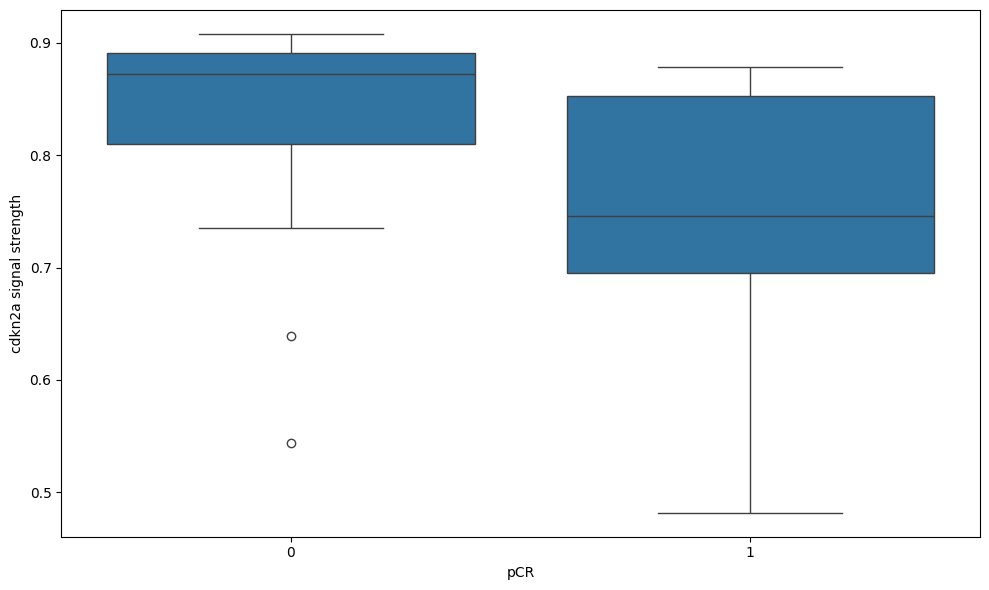

Mann-Whitney U检验 p值: 0.0050


In [12]:
from scipy.stats import zscore
# 获取模型的非零系数特征和零系数特征
nonzero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ != 0].tolist()
zero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ == 0].tolist()

# 检查缺失的特征
missing_nonzero = set(nonzero_features) - set(df_trans.columns)
missing_zero = set(zero_features) - set(df_trans.columns)

# 输出缺失特征的详细信息
print("\n特征缺失情况:")
print(f"模型中非零系数特征总数: {len(nonzero_features)}")
print(f"模型中零系数特征总数: {len(zero_features)}")

print(f"\n缺失的非零系数特征 ({len(missing_nonzero)}):")
if missing_nonzero:
    print("示例:", list(missing_nonzero)[:5], "..." if len(missing_nonzero) > 5 else "")
else:
    print("无")

print(f"\n缺失的零系数特征 ({len(missing_zero)}):")
if missing_zero:
    print("示例:", list(missing_zero)[:5], "..." if len(missing_zero) > 5 else "")
else:
    print("无")

# 为所有缺失特征添加零值列
missing_features = missing_nonzero.union(missing_zero)
if missing_features:
    print(f"\n总共添加 {len(missing_features)} 个缺失特征的零值列")
    for feature in missing_features:
        df_trans[feature] = 0

# 可以添加更详细的非零特征分析
if missing_nonzero:
    print("\n缺失的非零系数特征的重要性:")
    for feature in missing_nonzero:
        coef = cdkn2a_final_model.coef_[list(X_all_scaled.columns).index(feature)]
        print(f"{feature}: coefficient = {coef:.6f}")

# 确保特征顺序与训练集完全一致
df_trans = df_trans[X_all_scaled.columns]

# Z-score标准化
df_trans = pd.DataFrame(zscore(df_trans), 
                       index=df_trans.index, 
                       columns=df_trans.columns)

# 处理缺失值
if df_trans.isna().sum().sum() > 0:
    print(f"\n验证集中有 {df_trans.isna().sum().sum()} 个缺失值")
    df_trans = df_trans.fillna(0)

# 验证数据维度
print("\n数据维度检查:")
print(f"训练数据特征数: {X_all_scaled.shape[1]}")
print(f"验证集特征数: {df_trans.shape[1]}")
assert df_trans.shape[1] == X_all_scaled.shape[1], "特征数不匹配！"
assert all(df_trans.columns == X_all_scaled.columns), "特征顺序不匹配！"

# 在验证集上进行预测
print("\n在独立验证集上进行预测...")
cdkn2a_validation_pred = cdkn2a_final_model.predict(df_trans)

# 创建预测结果数据框
prediction_df = pd.DataFrame({
    'Sample': df_trans.index,
    'Predicted_cdkn2a': cdkn2a_validation_pred
})

# 保存预测结果
prediction_df.to_csv('independent_validation_cdkn2a_predictions.csv', index=False)
print("预测结果已保存到 'independent_validation_cdkn2a_predictions.csv'")

# 输出预测统计信息
print("\n预测值统计：")
print(pd.Series(cdkn2a_validation_pred).describe())

# 加载数据
from scipy.stats import mannwhitneyu
# 读取两个数据集
prediction_df = pd.read_csv('independent_validation_cdkn2a_predictions.csv', index_col=0)
df_transneo = pd.read_csv('./final_data/table.1-1.IndependentVal_Sammut2021Dis.ER-HER2-.txt', index_col=0, sep='\t')

# 基于索引合并两个数据框
merged_df = pd.merge(prediction_df, df_transneo, left_index=True, right_index=True, how='inner')

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='pCR', y='Predicted_cdkn2a', data=merged_df)
# plt.title('MTORC1信号预测值在pCR和非pCR组中的分布')
plt.xlabel('pCR')
plt.ylabel('cdkn2a signal strength')
plt.tight_layout()
plt.show()

# 进行统计检验
stat, pval = mannwhitneyu(
    merged_df[merged_df['pCR']==1]['Predicted_cdkn2a'],
    merged_df[merged_df['pCR']==0]['Predicted_cdkn2a']
)
print(f'Mann-Whitney U检验 p值: {pval:.4f}')

#### hoog


特征缺失情况:
模型中非零系数特征总数: 15
模型中零系数特征总数: 692

缺失的非零系数特征 (0):
无

缺失的零系数特征 (0):
无

验证集中有 156 个缺失值

数据维度检查:
训练数据特征数: 707
验证集特征数: 707

在独立验证集上进行预测...
预测结果已保存到 'hoog_independent_validation_cdkn2a_predictions.csv'

预测值统计：
count    52.000000
mean      0.843333
std       0.083614
min       0.622425
25%       0.794470
50%       0.859790
75%       0.903461
max       0.970884
dtype: float64


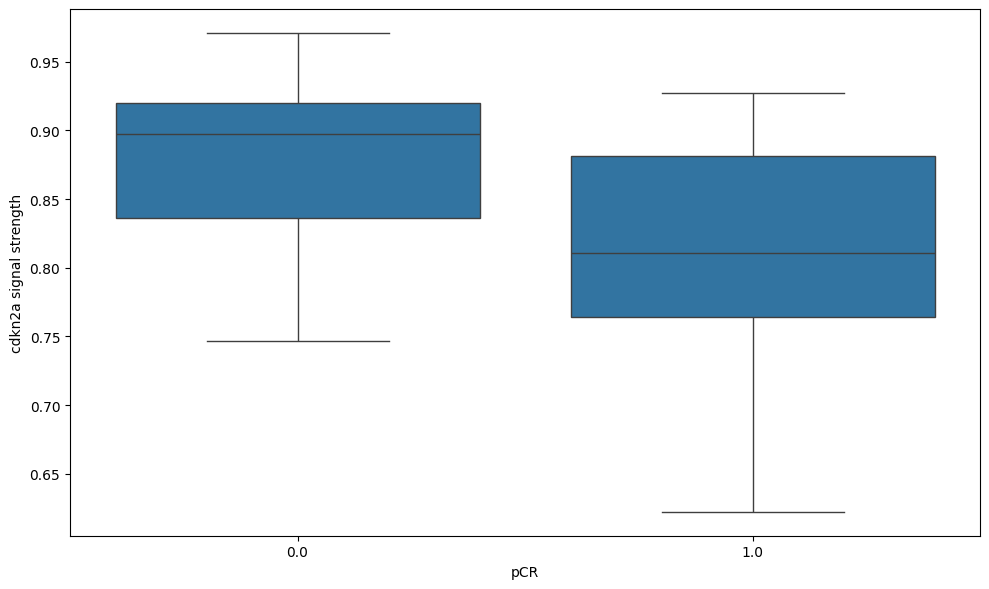

Mann-Whitney U检验 p值: 0.0028


In [17]:
from scipy.stats import zscore
# 获取模型的非零系数特征和零系数特征
nonzero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ != 0].tolist()
zero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ == 0].tolist()

# 检查缺失的特征
missing_nonzero = set(nonzero_features) - set(df_hoog.columns)
missing_zero = set(zero_features) - set(df_hoog.columns)

# 输出缺失特征的详细信息
print("\n特征缺失情况:")
print(f"模型中非零系数特征总数: {len(nonzero_features)}")
print(f"模型中零系数特征总数: {len(zero_features)}")

print(f"\n缺失的非零系数特征 ({len(missing_nonzero)}):")
if missing_nonzero:
    print("示例:", list(missing_nonzero)[:5], "..." if len(missing_nonzero) > 5 else "")
else:
    print("无")

print(f"\n缺失的零系数特征 ({len(missing_zero)}):")
if missing_zero:
    print("示例:", list(missing_zero)[:5], "..." if len(missing_zero) > 5 else "")
else:
    print("无")

# 为所有缺失特征添加零值列
missing_features = missing_nonzero.union(missing_zero)
if missing_features:
    print(f"\n总共添加 {len(missing_features)} 个缺失特征的零值列")
    for feature in missing_features:
        df_hoog[feature] = 0

# 可以添加更详细的非零特征分析
if missing_nonzero:
    print("\n缺失的非零系数特征的重要性:")
    for feature in missing_nonzero:
        coef = cdkn2a_final_model.coef_[list(X_all_scaled.columns).index(feature)]
        print(f"{feature}: coefficient = {coef:.6f}")

# 确保特征顺序与训练集完全一致
df_hoog = df_hoog[X_all_scaled.columns]

# Z-score标准化
df_hoog = pd.DataFrame(zscore(df_hoog), 
                       index=df_hoog.index, 
                       columns=df_hoog.columns)

# 处理缺失值
if df_hoog.isna().sum().sum() > 0:
    print(f"\n验证集中有 {df_hoog.isna().sum().sum()} 个缺失值")
    df_hoog = df_hoog.fillna(0)

# 验证数据维度
print("\n数据维度检查:")
print(f"训练数据特征数: {X_all_scaled.shape[1]}")
print(f"验证集特征数: {df_hoog.shape[1]}")
assert df_hoog.shape[1] == X_all_scaled.shape[1], "特征数不匹配！"
assert all(df_hoog.columns == X_all_scaled.columns), "特征顺序不匹配！"

# 在验证集上进行预测
print("\n在独立验证集上进行预测...")
cdkn2a_validation_pred = cdkn2a_final_model.predict(df_hoog)

# 创建预测结果数据框
prediction_df = pd.DataFrame({
    'Sample': df_hoog.index,
    'Predicted_cdkn2a': cdkn2a_validation_pred
})

# 保存预测结果
prediction_df.to_csv('hoog_independent_validation_cdkn2a_predictions.csv', index=False)
print("预测结果已保存到 'hoog_independent_validation_cdkn2a_predictions.csv'")

# 输出预测统计信息
print("\n预测值统计：")
print(pd.Series(cdkn2a_validation_pred).describe())

# 加载数据
from scipy.stats import mannwhitneyu
# 读取两个数据集
prediction_df = pd.read_csv('hoog_independent_validation_cdkn2a_predictions.csv', index_col=0)
df_hoogg = pd.read_csv('./final_data/table.1-1.IndependentVal_Hoogstraat2023.ER-HER2-.txt', index_col=0, sep='\t')

# 基于索引合并两个数据框
merged_df = pd.merge(prediction_df, df_hoogg, left_index=True, right_index=True, how='inner')

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='pCR', y='Predicted_cdkn2a', data=merged_df)
# plt.title('MTORC1信号预测值在pCR和非pCR组中的分布')
plt.xlabel('pCR')
plt.ylabel('cdkn2a signal strength')
plt.tight_layout()
plt.show()

# 进行统计检验
stat, pval = mannwhitneyu(
    merged_df[merged_df['pCR']==1]['Predicted_cdkn2a'],
    merged_df[merged_df['pCR']==0]['Predicted_cdkn2a']
)
print(f'Mann-Whitney U检验 p值: {pval:.4f}')

#### wof


特征缺失情况:
模型中非零系数特征总数: 15
模型中零系数特征总数: 692

缺失的非零系数特征 (0):
无

缺失的零系数特征 (0):
无

验证集中有 38532 个缺失值

数据维度检查:
训练数据特征数: 707
验证集特征数: 707

在独立验证集上进行预测...
预测结果已保存到 'wolf_independent_validation_cdkn2a_predictions.csv'

预测值统计：
count    988.000000
mean       0.843333
std        0.074227
min        0.498693
25%        0.808766
50%        0.869462
75%        0.894748
max        0.938801
dtype: float64


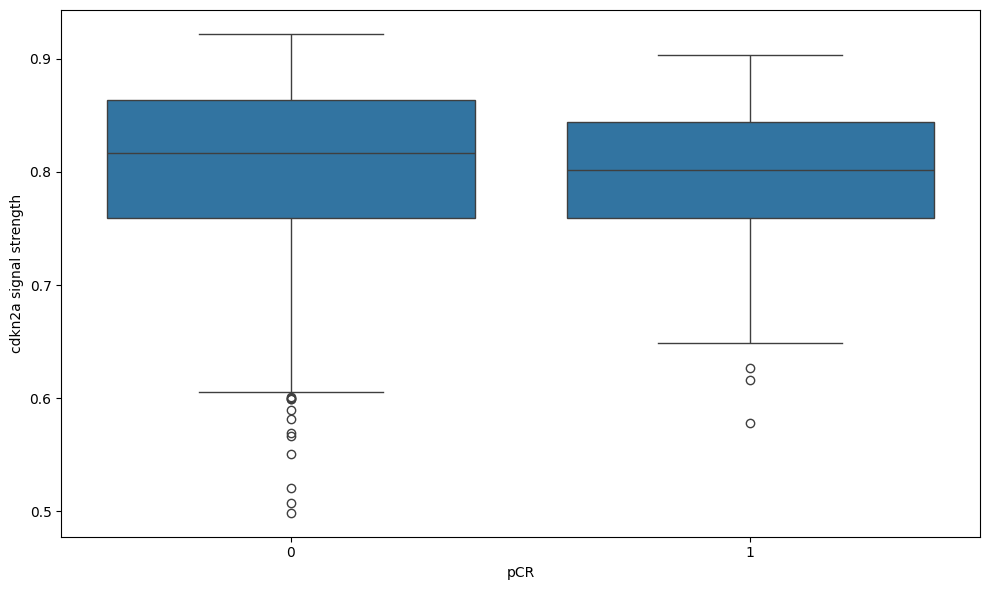

Mann-Whitney U检验 p值: 0.0834


In [28]:
from scipy.stats import zscore
# 获取模型的非零系数特征和零系数特征
nonzero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ != 0].tolist()
zero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ == 0].tolist()

# 检查缺失的特征
missing_nonzero = set(nonzero_features) - set(df_wolf.columns)
missing_zero = set(zero_features) - set(df_wolf.columns)

# 输出缺失特征的详细信息
print("\n特征缺失情况:")
print(f"模型中非零系数特征总数: {len(nonzero_features)}")
print(f"模型中零系数特征总数: {len(zero_features)}")

print(f"\n缺失的非零系数特征 ({len(missing_nonzero)}):")
if missing_nonzero:
    print("示例:", list(missing_nonzero)[:5], "..." if len(missing_nonzero) > 5 else "")
else:
    print("无")

print(f"\n缺失的零系数特征 ({len(missing_zero)}):")
if missing_zero:
    print("示例:", list(missing_zero)[:5], "..." if len(missing_zero) > 5 else "")
else:
    print("无")

# 为所有缺失特征添加零值列
missing_features = missing_nonzero.union(missing_zero)
if missing_features:
    print(f"\n总共添加 {len(missing_features)} 个缺失特征的零值列")
    for feature in missing_features:
        df_wolf[feature] = 0

# 可以添加更详细的非零特征分析
if missing_nonzero:
    print("\n缺失的非零系数特征的重要性:")
    for feature in missing_nonzero:
        coef = cdkn2a_final_model.coef_[list(X_all_scaled.columns).index(feature)]
        print(f"{feature}: coefficient = {coef:.6f}")

# 确保特征顺序与训练集完全一致
df_wolf = df_wolf[X_all_scaled.columns]

# Z-score标准化
df_wolf = pd.DataFrame(zscore(df_wolf), 
                       index=df_wolf.index, 
                       columns=df_wolf.columns)

# 处理缺失值
if df_wolf.isna().sum().sum() > 0:
    print(f"\n验证集中有 {df_wolf.isna().sum().sum()} 个缺失值")
    df_wolf = df_wolf.fillna(0)

# 验证数据维度
print("\n数据维度检查:")
print(f"训练数据特征数: {X_all_scaled.shape[1]}")
print(f"验证集特征数: {df_wolf.shape[1]}")
assert df_wolf.shape[1] == X_all_scaled.shape[1], "特征数不匹配！"
assert all(df_wolf.columns == X_all_scaled.columns), "特征顺序不匹配！"

# 在验证集上进行预测
print("\n在独立验证集上进行预测...")
cdkn2a_validation_pred = cdkn2a_final_model.predict(df_wolf)

# 创建预测结果数据框
prediction_df = pd.DataFrame({
    'Sample': df_wolf.index,
    'Predicted_cdkn2a': cdkn2a_validation_pred
})

# 保存预测结果
prediction_df.to_csv('wolf_independent_validation_cdkn2a_predictions.csv', index=False)
print("预测结果已保存到 'wolf_independent_validation_cdkn2a_predictions.csv'")

# 输出预测统计信息
print("\n预测值统计：")
print(pd.Series(cdkn2a_validation_pred).describe())

# 加载数据
from scipy.stats import mannwhitneyu
# 读取两个数据集
prediction_df = pd.read_csv('wolf_independent_validation_cdkn2a_predictions.csv', index_col=0)
df_wolff = pd.read_csv('./final_data/table.1-1.IndependentVal_Wolf2022.ER-HER2-.txt', index_col=0, sep='\t')

# 基于索引合并两个数据框
merged_df = pd.merge(prediction_df, df_wolff, left_index=True, right_index=True, how='inner')

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='pCR', y='Predicted_cdkn2a', data=merged_df)
# plt.title('MTORC1信号预测值在pCR和非pCR组中的分布')
plt.xlabel('pCR')
plt.ylabel('cdkn2a signal strength')
plt.tight_layout()
plt.show()

# 进行统计检验
stat, pval = mannwhitneyu(
    merged_df[merged_df['pCR']==1]['Predicted_cdkn2a'],
    merged_df[merged_df['pCR']==0]['Predicted_cdkn2a']
)
print(f'Mann-Whitney U检验 p值: {pval:.4f}')

#### bright


特征缺失情况:
模型中非零系数特征总数: 15
模型中零系数特征总数: 692

缺失的非零系数特征 (0):
无

缺失的零系数特征 (3):
示例: ['RMI2', 'POLR2A', 'RPL5'] 

总共添加 3 个缺失特征的零值列

验证集中有 1928 个缺失值

数据维度检查:
训练数据特征数: 707
验证集特征数: 707

在独立验证集上进行预测...
预测结果已保存到 'bright_independent_validation_cdkn2a_predictions.csv'

预测值统计：
count    482.000000
mean       0.843333
std        0.073827
min        0.512317
25%        0.798922
50%        0.855013
75%        0.903146
max        0.962274
dtype: float64


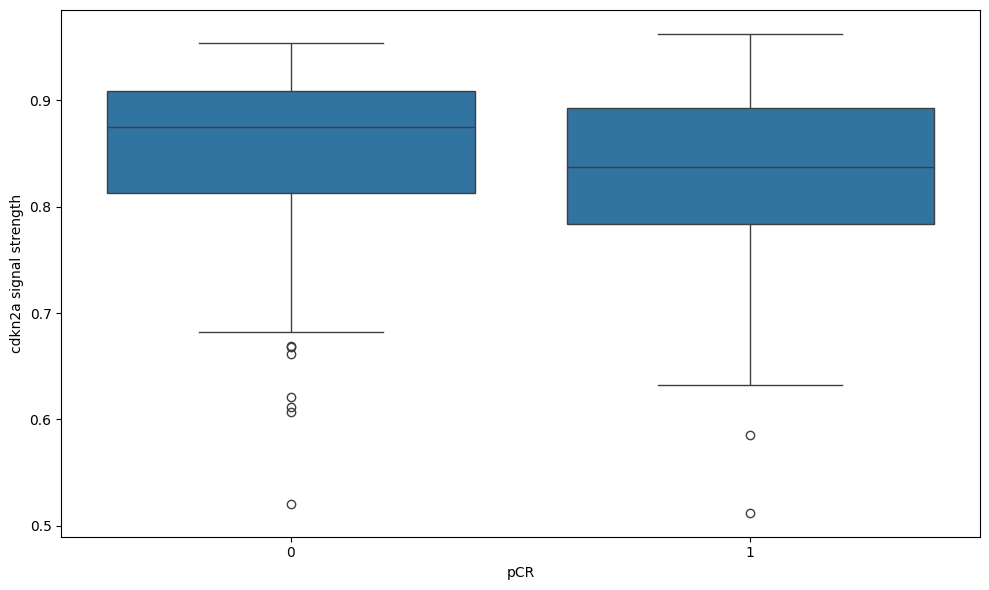

Mann-Whitney U检验 p值: 0.0001


In [20]:
from scipy.stats import zscore
# 获取模型的非零系数特征和零系数特征
nonzero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ != 0].tolist()
zero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ == 0].tolist()

# 检查缺失的特征
missing_nonzero = set(nonzero_features) - set(df_bright.columns)
missing_zero = set(zero_features) - set(df_bright.columns)

# 输出缺失特征的详细信息
print("\n特征缺失情况:")
print(f"模型中非零系数特征总数: {len(nonzero_features)}")
print(f"模型中零系数特征总数: {len(zero_features)}")

print(f"\n缺失的非零系数特征 ({len(missing_nonzero)}):")
if missing_nonzero:
    print("示例:", list(missing_nonzero)[:5], "..." if len(missing_nonzero) > 5 else "")
else:
    print("无")

print(f"\n缺失的零系数特征 ({len(missing_zero)}):")
if missing_zero:
    print("示例:", list(missing_zero)[:5], "..." if len(missing_zero) > 5 else "")
else:
    print("无")

# 为所有缺失特征添加零值列
missing_features = missing_nonzero.union(missing_zero)
if missing_features:
    print(f"\n总共添加 {len(missing_features)} 个缺失特征的零值列")
    for feature in missing_features:
        df_bright[feature] = 0

# 可以添加更详细的非零特征分析
if missing_nonzero:
    print("\n缺失的非零系数特征的重要性:")
    for feature in missing_nonzero:
        coef = cdkn2a_final_model.coef_[list(X_all_scaled.columns).index(feature)]
        print(f"{feature}: coefficient = {coef:.6f}")

# 确保特征顺序与训练集完全一致
df_bright = df_bright[X_all_scaled.columns]

# Z-score标准化
df_bright = pd.DataFrame(zscore(df_bright), 
                       index=df_bright.index, 
                       columns=df_bright.columns)

# 处理缺失值
if df_bright.isna().sum().sum() > 0:
    print(f"\n验证集中有 {df_bright.isna().sum().sum()} 个缺失值")
    df_bright = df_bright.fillna(0)

# 验证数据维度
print("\n数据维度检查:")
print(f"训练数据特征数: {X_all_scaled.shape[1]}")
print(f"验证集特征数: {df_bright.shape[1]}")
assert df_bright.shape[1] == X_all_scaled.shape[1], "特征数不匹配！"
assert all(df_bright.columns == X_all_scaled.columns), "特征顺序不匹配！"

# 在验证集上进行预测
print("\n在独立验证集上进行预测...")
cdkn2a_validation_pred = cdkn2a_final_model.predict(df_bright)

# 创建预测结果数据框
prediction_df = pd.DataFrame({
    'Sample': df_bright.index,
    'Predicted_cdkn2a': cdkn2a_validation_pred
})

# 保存预测结果
prediction_df.to_csv('bright_independent_validation_cdkn2a_predictions.csv', index=False)
print("预测结果已保存到 'bright_independent_validation_cdkn2a_predictions.csv'")

# 输出预测统计信息
print("\n预测值统计：")
print(pd.Series(cdkn2a_validation_pred).describe())

# 加载数据
from scipy.stats import mannwhitneyu
# 读取两个数据集
prediction_df = pd.read_csv('bright_independent_validation_cdkn2a_predictions.csv', index_col=0)
df_brightt = pd.read_csv('./final_data/table.1-1.IndependentVal_BrightNess.ER-HER2-.txt', index_col=0, sep='\t')

# 基于索引合并两个数据框
merged_df = pd.merge(prediction_df, df_brightt, left_index=True, right_index=True, how='inner')

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='pCR', y='Predicted_cdkn2a', data=merged_df)
# plt.title('MTORC1信号预测值在pCR和非pCR组中的分布')
plt.xlabel('pCR')
plt.ylabel('cdkn2a signal strength')
plt.tight_layout()
plt.show()

# 进行统计检验
stat, pval = mannwhitneyu(
    merged_df[merged_df['pCR']==1]['Predicted_cdkn2a'],
    merged_df[merged_df['pCR']==0]['Predicted_cdkn2a']
)
print(f'Mann-Whitney U检验 p值: {pval:.4f}')

#### hatz


特征缺失情况:
模型中非零系数特征总数: 15
模型中零系数特征总数: 692

缺失的非零系数特征 (1):
示例: ['UBASH3B'] 

缺失的零系数特征 (54):
示例: ['DTX1', 'BBC3', 'CALM3', 'RICTOR', 'NUMB'] ...

总共添加 55 个缺失特征的零值列

缺失的非零系数特征的重要性:
UBASH3B: coefficient = -0.004081

验证集中有 17050 个缺失值

数据维度检查:
训练数据特征数: 707
验证集特征数: 707

在独立验证集上进行预测...
预测结果已保存到 'hatz_independent_validation_cdkn2a_predictions.csv'

预测值统计：
count    310.000000
mean       0.843333
std        0.073906
min        0.510889
25%        0.816762
50%        0.867900
75%        0.892487
max        0.969381
dtype: float64


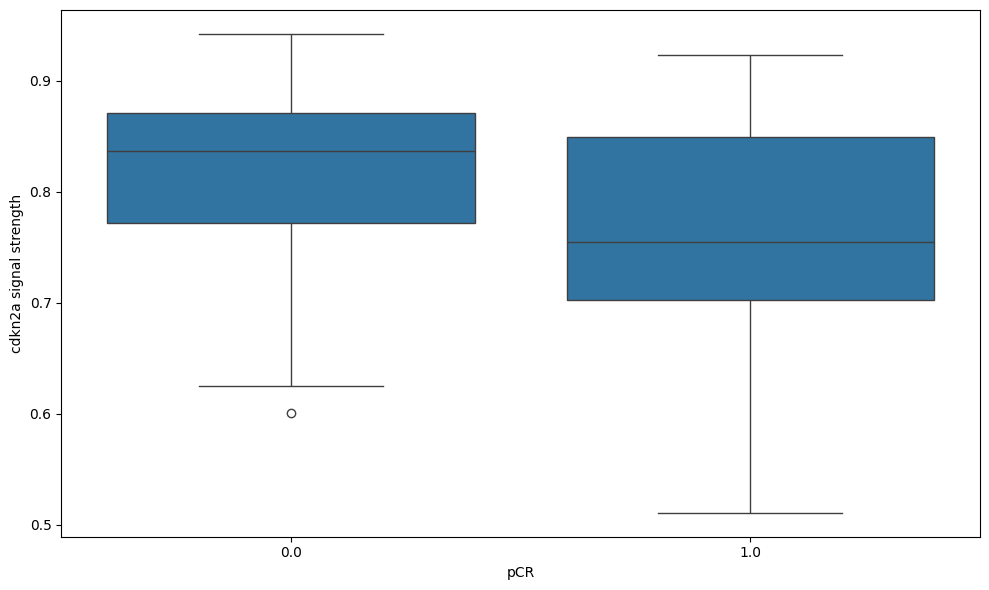

Mann-Whitney U检验 p值: 0.0061


In [26]:
from scipy.stats import zscore
# 获取模型的非零系数特征和零系数特征
nonzero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ != 0].tolist()
zero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ == 0].tolist()

# 检查缺失的特征
missing_nonzero = set(nonzero_features) - set(df_hatz.columns)
missing_zero = set(zero_features) - set(df_hatz.columns)

# 输出缺失特征的详细信息
print("\n特征缺失情况:")
print(f"模型中非零系数特征总数: {len(nonzero_features)}")
print(f"模型中零系数特征总数: {len(zero_features)}")

print(f"\n缺失的非零系数特征 ({len(missing_nonzero)}):")
if missing_nonzero:
    print("示例:", list(missing_nonzero)[:5], "..." if len(missing_nonzero) > 5 else "")
else:
    print("无")

print(f"\n缺失的零系数特征 ({len(missing_zero)}):")
if missing_zero:
    print("示例:", list(missing_zero)[:5], "..." if len(missing_zero) > 5 else "")
else:
    print("无")

# 为所有缺失特征添加零值列
missing_features = missing_nonzero.union(missing_zero)
if missing_features:
    print(f"\n总共添加 {len(missing_features)} 个缺失特征的零值列")
    for feature in missing_features:
        df_hatz[feature] = 0

# 可以添加更详细的非零特征分析
if missing_nonzero:
    print("\n缺失的非零系数特征的重要性:")
    for feature in missing_nonzero:
        coef = cdkn2a_final_model.coef_[list(X_all_scaled.columns).index(feature)]
        print(f"{feature}: coefficient = {coef:.6f}")

# 确保特征顺序与训练集完全一致
df_hatz = df_hatz[X_all_scaled.columns]

# Z-score标准化
df_hatz = pd.DataFrame(zscore(df_hatz), 
                       index=df_hatz.index, 
                       columns=df_hatz.columns)

# 处理缺失值
if df_hatz.isna().sum().sum() > 0:
    print(f"\n验证集中有 {df_hatz.isna().sum().sum()} 个缺失值")
    df_hatz = df_hatz.fillna(0)

# 验证数据维度
print("\n数据维度检查:")
print(f"训练数据特征数: {X_all_scaled.shape[1]}")
print(f"验证集特征数: {df_hatz.shape[1]}")
assert df_hatz.shape[1] == X_all_scaled.shape[1], "特征数不匹配！"
assert all(df_hatz.columns == X_all_scaled.columns), "特征顺序不匹配！"

# 在验证集上进行预测
print("\n在独立验证集上进行预测...")
cdkn2a_validation_pred = cdkn2a_final_model.predict(df_hatz)

# 创建预测结果数据框
prediction_df = pd.DataFrame({
    'Sample': df_hatz.index,
    'Predicted_cdkn2a': cdkn2a_validation_pred
})

# 保存预测结果
prediction_df.to_csv('hatz_independent_validation_cdkn2a_predictions.csv', index=False)
print("预测结果已保存到 'hatz_independent_validation_cdkn2a_predictions.csv'")

# 输出预测统计信息
print("\n预测值统计：")
print(pd.Series(cdkn2a_validation_pred).describe())

# 加载数据
from scipy.stats import mannwhitneyu
# 读取两个数据集
prediction_df = pd.read_csv('hatz_independent_validation_cdkn2a_predictions.csv', index_col=0)
df_hatzz = pd.read_csv('./final_data/table.1-1.IndependentVal_Hatzis.ER-HER2-.txt', index_col=0, sep='\t')

# 基于索引合并两个数据框
merged_df = pd.merge(prediction_df, df_hatzz, left_index=True, right_index=True, how='inner')

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='pCR', y='Predicted_cdkn2a', data=merged_df)
# plt.title('MTORC1信号预测值在pCR和非pCR组中的分布')
plt.xlabel('pCR')
plt.ylabel('cdkn2a signal strength')
plt.tight_layout()
plt.show()

# 进行统计检验
stat, pval = mannwhitneyu(
    merged_df[merged_df['pCR']==1]['Predicted_cdkn2a'],
    merged_df[merged_df['pCR']==0]['Predicted_cdkn2a']
)
print(f'Mann-Whitney U检验 p值: {pval:.4f}')

#### samval


特征缺失情况:
模型中非零系数特征总数: 15
模型中零系数特征总数: 692

缺失的非零系数特征 (0):
无

缺失的零系数特征 (1):
示例: ['AK6'] 

总共添加 1 个缺失特征的零值列

验证集中有 27 个缺失值

数据维度检查:
训练数据特征数: 707
验证集特征数: 707

在独立验证集上进行预测...
预测结果已保存到 'sam_independent_validation_cdkn2a_predictions.csv'

预测值统计：
count    27.000000
mean      0.843333
std       0.088964
min       0.475556
25%       0.829794
50%       0.875731
75%       0.890861
max       0.924216
dtype: float64


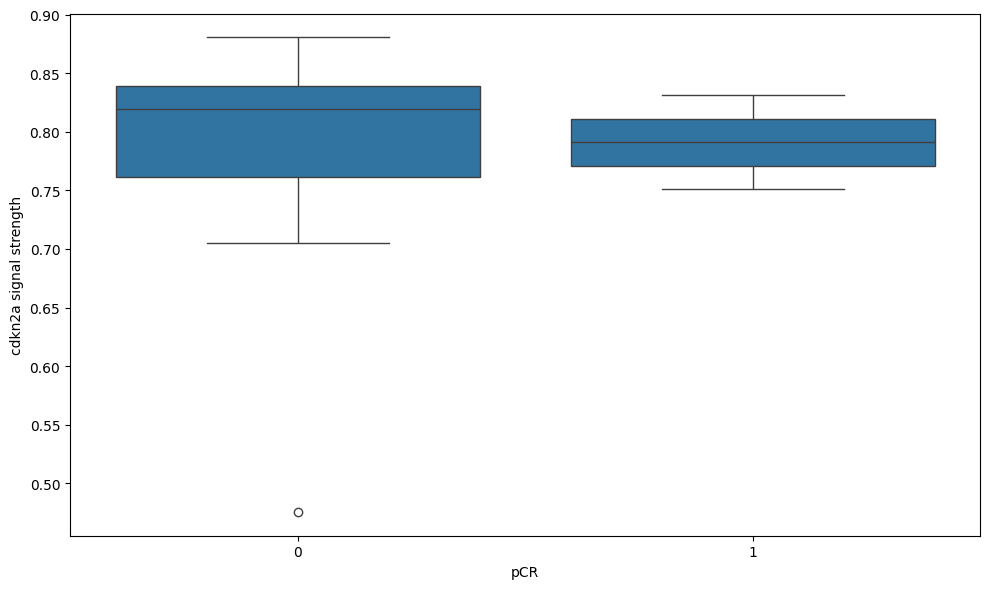

Mann-Whitney U检验 p值: 1.0000


In [31]:
from scipy.stats import zscore
# 获取模型的非零系数特征和零系数特征
nonzero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ != 0].tolist()
zero_features = X_all_scaled.columns[cdkn2a_final_model.coef_ == 0].tolist()

# 检查缺失的特征
missing_nonzero = set(nonzero_features) - set(df_sam.columns)
missing_zero = set(zero_features) - set(df_sam.columns)

# 输出缺失特征的详细信息
print("\n特征缺失情况:")
print(f"模型中非零系数特征总数: {len(nonzero_features)}")
print(f"模型中零系数特征总数: {len(zero_features)}")

print(f"\n缺失的非零系数特征 ({len(missing_nonzero)}):")
if missing_nonzero:
    print("示例:", list(missing_nonzero)[:5], "..." if len(missing_nonzero) > 5 else "")
else:
    print("无")

print(f"\n缺失的零系数特征 ({len(missing_zero)}):")
if missing_zero:
    print("示例:", list(missing_zero)[:5], "..." if len(missing_zero) > 5 else "")
else:
    print("无")

# 为所有缺失特征添加零值列
missing_features = missing_nonzero.union(missing_zero)
if missing_features:
    print(f"\n总共添加 {len(missing_features)} 个缺失特征的零值列")
    for feature in missing_features:
        df_sam[feature] = 0

# 可以添加更详细的非零特征分析
if missing_nonzero:
    print("\n缺失的非零系数特征的重要性:")
    for feature in missing_nonzero:
        coef = cdkn2a_final_model.coef_[list(X_all_scaled.columns).index(feature)]
        print(f"{feature}: coefficient = {coef:.6f}")

# 确保特征顺序与训练集完全一致
df_sam = df_sam[X_all_scaled.columns]

# Z-score标准化
df_sam = pd.DataFrame(zscore(df_sam), 
                       index=df_sam.index, 
                       columns=df_sam.columns)

# 处理缺失值
if df_sam.isna().sum().sum() > 0:
    print(f"\n验证集中有 {df_sam.isna().sum().sum()} 个缺失值")
    df_sam = df_sam.fillna(0)

# 验证数据维度
print("\n数据维度检查:")
print(f"训练数据特征数: {X_all_scaled.shape[1]}")
print(f"验证集特征数: {df_sam.shape[1]}")
assert df_sam.shape[1] == X_all_scaled.shape[1], "特征数不匹配！"
assert all(df_sam.columns == X_all_scaled.columns), "特征顺序不匹配！"

# 在验证集上进行预测
print("\n在独立验证集上进行预测...")
cdkn2a_validation_pred = cdkn2a_final_model.predict(df_sam)

# 创建预测结果数据框
prediction_df = pd.DataFrame({
    'Sample': df_sam.index,
    'Predicted_cdkn2a': cdkn2a_validation_pred
})

# 保存预测结果
prediction_df.to_csv('sam_independent_validation_cdkn2a_predictions.csv', index=False)
print("预测结果已保存到 'sam_independent_validation_cdkn2a_predictions.csv'")

# 输出预测统计信息
print("\n预测值统计：")
print(pd.Series(cdkn2a_validation_pred).describe())

# 加载数据
from scipy.stats import mannwhitneyu
# 读取两个数据集
prediction_df = pd.read_csv('sam_independent_validation_cdkn2a_predictions.csv', index_col=0)
df_samm = pd.read_csv('./final_data/table.2-1.IndependentVal_Sammut2021Val.ER-HER2-.txt', index_col=0, sep='\t')

# 基于索引合并两个数据框
merged_df = pd.merge(prediction_df, df_samm, left_index=True, right_index=True, how='inner')

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='pCR', y='Predicted_cdkn2a', data=merged_df)
# plt.title('MTORC1信号预测值在pCR和非pCR组中的分布')
plt.xlabel('pCR')
plt.ylabel('cdkn2a signal strength')
plt.tight_layout()
plt.show()

# 进行统计检验
stat, pval = mannwhitneyu(
    merged_df[merged_df['pCR']==1]['Predicted_cdkn2a'],
    merged_df[merged_df['pCR']==0]['Predicted_cdkn2a']
)
print(f'Mann-Whitney U检验 p值: {pval:.4f}')